In [1]:

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

In [2]:
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [10]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()


░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ = 1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

<IPython.core.display.Latex object>

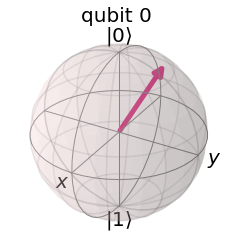

In [12]:
#simulating teleportation protocol
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)


In [13]:
init_gate = Initialize(psi)
init_gate.label = "init"

In [14]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.55521-0.69032j,-0.21459+0.41127j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐                 
«  q_0: ─░─┤M├─────────────────
«        ░ └╥┘┌─┐              
«  q_1: ─░──╫─┤M├──────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─
«        ░  ║  ║  └─╥─┘  └─╥─┘ 
«           ║  ║    ║   ┌──╨──┐
«crz: 1/════╩══╬════╬═══╡ = 1 ╞
«           0  ║ ┌──╨──┐└─────┘
«crx: 1/═══════╩═╡ = 1 ╞═══════
«              0 └─────┘

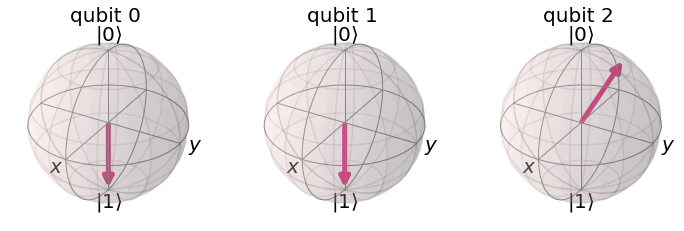

In [15]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

In [16]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [17]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.55521-0.69032j,-0.21459+0.41127j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐                                 
«  q_0: ─░─┤M├─────────────────────────────────
«        ░ └╥┘┌─┐                              
«  q_1: ─░──╫─┤M├──────────────────────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├
«        ░  ║  ║  └─╥─┘  └─╥─┘ └──────────────┘
«           ║  ║    ║   ┌──╨──┐                
«crz: 1/════╩══╬════╬═══╡ = 1 ╞════════════════
«           0  ║ ┌──╨──┐└─────┘                
«crx: 1/═══════╩═╡ = 1 ╞═══════════════════════
«              0 └─────┘

In [18]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.55521-0.69032j,-0.21459+0.41127j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
 c0: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐                                    
«  q_0: ─░─┤M├────────────────────────────────────
«        ░ └╥┘┌─┐                                 
«  q_1: ─░──╫─┤M├─────────────────────────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐┌─┐
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├┤M├
«        ░  ║  ║  └─╥─┘  └─╥─┘ └──────────────┘└╥┘
«           ║  ║    ║   ┌──╨──┐                 ║ 
«crz: 1/════╩══╬════╬═══╡ = 1 ╞═════════════════╬═
«           0  ║ ┌──╨──┐└─────┘                 ║ 
«crx: 1/═══════╩═╡ = 1 ╞════════════════════════╬═
«              0 └─────┘                        ║ 
« c0: 1/════════════════════════════════════════╩═
«                                               0

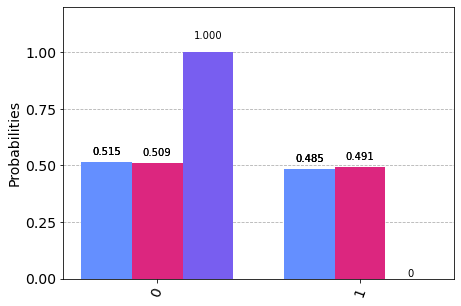

In [19]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

In [20]:
#simulating on real hardware
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [21]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
q_0: ┤ init(0.55521-0.69032j,-0.21459+0.41127j) ├─░────────────░───■──┤ H ├─░─»
     └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                  ░ └───┘┌─┴─┐ ░ └───┘      ░ »
q_2: ─────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                  ░      └───┘ ░            ░ »
c: 1/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                
«q_0: ──────■────────────────────
«           │                    
«q_1: ──■───┼────────────────────
«     ┌─┴─┐ │ ┌──────────────┐┌─┐
«q_2: ┤ X ├─■─┤ disentangler ├┤M├
«     └───┘   └──────────────┘└╥┘
«c: 1/═════════════════════════╩═
«                              0

In [25]:
# First, see what devices we are allowed to use by loading our saved accounts
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

In [24]:
# get the least-busy backend at IBM and run the quantum circuit there
# from qiskit.providers.ibmq import least_busy
# from qiskit.tools.monitor import job_monitor
# backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
#                                    not b.configuration().simulator and b.status().operational==True))
# t_qc = transpile(qc, backend, optimization_level=3)
# job = backend.run(t_qc)
# job_monitor(job)  # displays job status under cell

In [26]:
# Get the results and display them
# exp_result = job.result()
# exp_counts = exp_result.get_counts(qc)
# print(exp_counts)
# plot_histogram(exp_counts)

In [ ]:
#print(f"The experimental error rate : {exp_counts['1']*100/sum(exp_counts.values()):.3f}%")